In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 


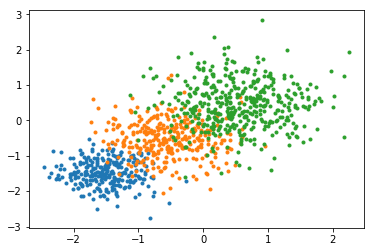

In [30]:
simulate = True
if not simulate:
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[components == k, 0], features[components == k, 1], '.')

# Set up the model

In [31]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(8.0)
#prior_params['alpha'].set(2.0)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [27]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [28]:
# run k-means init
n_kmeans_init = 50
init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [32]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0

print('Done. ')

BGFS
Iter: 0	 RMSE: 18.759132357664818	 Objective: 3655.846666455907
Iter: 10	 RMSE: 26.854948011003966	 Objective: 805.7320020167473
Iter: 20	 RMSE: 25.86303044952227	 Objective: 552.1514352036347
Iter: 30	 RMSE: 23.66155407082491	 Objective: 480.6960392510877
Iter: 40	 RMSE: 20.185992361180713	 Objective: 462.53047100040817
Iter: 50	 RMSE: 20.421266839425844	 Objective: 455.2988561716145
Iter: 60	 RMSE: 19.325725575407553	 Objective: 451.2992330346285
Iter: 70	 RMSE: 18.285872442081246	 Objective: 447.8923411981816
Iter: 80	 RMSE: 17.30945840158952	 Objective: 444.0980566497599
Iter: 90	 RMSE: 15.42272690295364	 Objective: 438.3937262312819
Iter: 100	 RMSE: 14.203491865182622	 Objective: 433.80339465070415
         Current function value: 432.082294
         Iterations: 100
         Function evaluations: 109
         Gradient evaluations: 109
Conditioned Newton:
i =  0
Iter: 110	 RMSE: 12.930158970229435	 Objective: 430.93563862183953
Iter: 120	 RMSE: 12.471283056723452	 Objective: 4

In [33]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [34]:
fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'ryan_{}_bnp_full_data_fit_alpha{}.json'.format(dataset_name, base_alpha)
json_output_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ../../../BNP_sensitivity/GMM_clustering/iris_fits/ryan_simulation_bnp_full_data_fit_alpha8.0.json
